In [15]:
import tempfile
import matplotlib.pyplot as plt
import pydicom
#from pydicom.data import get_testdata_file
import cv2
import os
from skimage import morphology
import math
import numpy as np
from scipy import ndimage
from tqdm import tqdm
import glob as glob
import SimpleITK as sitk
import sys
#from pydicom.encaps import encapsulate
#from pydicom.uid import JPEG2000
#from pydicom.pixel_data_handlers.util import apply_modality_lut
from imagecodecs import jpeg_encode
import imagecodecs
import random
from pydicom.uid import ExplicitVRLittleEndian
from imagecodecs import jpeg_encode
import imagecodecs
import pylibjpeg


def sorted_files(folder):
    ins=[]
    ser=[]
#     f= os.listdir(folder)
    f= sorted(glob.glob((folder + "/**/*.dcm"),recursive = True))
    for name in tqdm( f):
        itkimage = sitk.ReadImage(os.path.join(folder,name))
        temp= float(itkimage.GetMetaData('0020|0013')) # instance number 
        temp1= itkimage.GetMetaData('0020|000e') #series instance UID 
        row = itkimage.GetMetaData()
        ins.append(int(temp))
        ser.append(temp1)
    series=np.unique(ser)
    files=[[x for sr,_,x in sorted(zip(ser,ins,f)) if sr==s] for s in series]
    return files

def scan_func(path):
    f= sorted_files(path)
    series=[]
    files=[]
    for i in tqdm (range (len(f))):
        img=[]
        file=[]
        for filename in f[i]:
            itkimage = sitk.ReadImage(os.path.join(path,filename))
            numpyImage = sitk.GetArrayFromImage(itkimage)
            img.append(numpyImage[0,:,:])
            file.append(filename)
        series.append(img)
        files.append(file)
    return series,files




In [2]:
'''#path = input_folder="/home/abdullah/mri_fa/data_test/00093511"

#path = input_folder= r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_data\00093511"
path =input_folder= r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_data\00536351"
output_folder=r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_result"
#output_folder= "/home/abdullah/mri_fa/00093511/MRI_BRAIN_result"
scan_series,filenames = scan_func(input_folder)
scan, names = scan_series[9],filenames[9]
scan=np.asarray(scan)
dcmData = pydicom.dcmread(os.path.join(path,names[0]))
'''

'#path = input_folder="/home/abdullah/mri_fa/data_test/00093511"\n\n#path = input_folder= r"C:\\MRI_BRAIN_HEAD\\MRI_BRAIN_data\x0093511"\npath =input_folder= r"C:\\MRI_BRAIN_HEAD\\MRI_BRAIN_data\x0536351"\noutput_folder=r"C:\\MRI_BRAIN_HEAD\\MRI_BRAIN_result"\n#output_folder= "/home/abdullah/mri_fa/00093511/MRI_BRAIN_result"\nscan_series,filenames = scan_func(input_folder)\nscan, names = scan_series[9],filenames[9]\nscan=np.asarray(scan)\ndcmData = pydicom.dcmread(os.path.join(path,names[0]))\n'

In [3]:
'''a = (np.around(dcmData.ImageOrientationPatient, 0))
print("a",a)
for i in range(scan.shape[0]):
    name = names[i]
    img = scan[i, :, :]
    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
    r= dcmData.Rows
    c=dcmData.Columns
    
'''

'a = (np.around(dcmData.ImageOrientationPatient, 0))\nprint("a",a)\nfor i in range(scan.shape[0]):\n    name = names[i]\n    img = scan[i, :, :]\n    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it\'s pixel data to anonymized\n    r= dcmData.Rows\n    c=dcmData.Columns\n    \n'

In [4]:
#scan.shape

In [5]:
'''dcmData = pydicom.dcmread(os.path.join(path,names[20])) ##read file to change it's pixel data to anonymized
rows= dcmData.Rows
colomns=dcmData.Columns
dicom_img=dcmData.pixel_array
plt.imshow(scan[20,:,:],'gray')
plt.show()
image= scan#[20,:,:]
histogram, bin_edges = np.histogram(image, bins=256)
histogram'''

"dcmData = pydicom.dcmread(os.path.join(path,names[20])) ##read file to change it's pixel data to anonymized\nrows= dcmData.Rows\ncolomns=dcmData.Columns\ndicom_img=dcmData.pixel_array\nplt.imshow(scan[20,:,:],'gray')\nplt.show()\nimage= scan#[20,:,:]\nhistogram, bin_edges = np.histogram(image, bins=256)\nhistogram"

In [6]:
#bin_edges[-1]

In [7]:
'''plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
#plt.xlim([-10.0, 1500.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram) '''

'plt.figure()\nplt.title("Grayscale Histogram")\nplt.xlabel("grayscale value")\nplt.ylabel("pixel count")\n#plt.xlim([-10.0, 1500.0])  # <- named arguments do not work here\n\nplt.plot(bin_edges[0:-1], histogram) '

## FUNCTION FOR SAGITTAL - MAIN

In [2]:

def MRI_blurred_sag(image,dicom_img, rows, columns):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    #plt.imshow(gray,'gray')
    #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int(temp.shape[1]/2)
    temp[:,variable:] = 0
    #plt.imshow(temp,'gray')
    #plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
    
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

## FUNCTION FOR AXIAL - MAIN

In [3]:

def MRI_blurred_axial(image,dicom_img, rows, columns):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    #plt.imshow(gray,'gray')
    #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int((temp.shape[0])/2)
    temp[variable:,:] = 0
    #plt.imshow(temp,'gray')
    #plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
    #print(rows,columns)
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

## FUNCTION FOR CORONAL - MAIN

In [4]:

def MRI_blurred_coronal(image,dicom_img, rows, columns):
    #if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
    #     print("equal")
    #else:
    #    image=dicom_img
    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.morphology.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    #plt.imshow(gray,'gray')
    #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    #plt.imshow(temp,'gray')
    #plt.show()
    #gray = np.where((gray==255), 0, 1)
    #gray[:,150:] = 0
   
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
   # if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
   #     out = np.where((temp==1), blurred_img, image)
   # else:
   #     out = np.where((temp==1), blurred_img, dicom_img)
    #out = np.where(skull>0,image,out)
    #plt.imshow(out,'gray')
    #plt.show()
    return out

### EXTRA ----

In [11]:
#out=MRI_blurred_axial(image,dicom_img ,rows, colomns)

In [12]:
'''np.unique(image)
#imagee = image>-50
head = image>100
skull = image>500
#skull = skull>1
ROI=np.logical_xor(head,skull)'''

'np.unique(image)\n#imagee = image>-50\nhead = image>100\nskull = image>500\n#skull = skull>1\nROI=np.logical_xor(head,skull)'

In [13]:

#plt.imshow(dcmData.pixel_array, 'gray')

In [14]:
#plt.imshow(ROI,'gray')

In [15]:
'''kernel = np.ones((30, 30), np.uint8)
imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
imagee = ndimage.morphology.binary_fill_holes(imagee)
imagee = imagee.astype(np.uint8)
plt.imshow(imagee,'gray')'''

"kernel = np.ones((30, 30), np.uint8)\nimagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)\nimagee = ndimage.morphology.binary_fill_holes(imagee)\nimagee = imagee.astype(np.uint8)\nplt.imshow(imagee,'gray')"

In [16]:
'''contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
gray = np.zeros_like(imagee)
gray = cv2.drawContours(gray, contours,0, 255,2 )
plt.imshow(gray,'gray')
plt.show()


temp=gray.copy()
temp=np.where((temp==255),1,0)
print(temp.shape)
variable=int((temp.shape[0])/2)
temp[variable:,:] = 0
plt.imshow(temp,'gray')
plt.show()

#gray = np.where((gray==255), 0, 1)
#gray[:,150:] = 0
print(temp.shape)
colomns=temp.shape[0]
rows=temp.shape[1]
r=[[random.randint(-250,500) for i in range(rows)] for j in range(colomns)]
r=np.asarray(r)
blurred_img= np.multiply(temp,r)
out = np.where((temp==1), blurred_img, image)
#out = np.where(skull>0,image,out)
plt.imshow(out,'gray')
plt.show()






'''

"contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)\ngray = np.zeros_like(imagee)\ngray = cv2.drawContours(gray, contours,0, 255,2 )\nplt.imshow(gray,'gray')\nplt.show()\n\n\ntemp=gray.copy()\ntemp=np.where((temp==255),1,0)\nprint(temp.shape)\nvariable=int((temp.shape[0])/2)\ntemp[variable:,:] = 0\nplt.imshow(temp,'gray')\nplt.show()\n\n#gray = np.where((gray==255), 0, 1)\n#gray[:,150:] = 0\nprint(temp.shape)\ncolomns=temp.shape[0]\nrows=temp.shape[1]\nr=[[random.randint(-250,500) for i in range(rows)] for j in range(colomns)]\nr=np.asarray(r)\nblurred_img= np.multiply(temp,r)\nout = np.where((temp==1), blurred_img, image)\n#out = np.where(skull>0,image,out)\nplt.imshow(out,'gray')\nplt.show()\n\n\n\n\n\n\n"

### EXTRA ENDS ---

## MAIN FUNCTION CALLING 

In [5]:
from skimage.metrics import structural_similarity

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [6]:
def get_imgs_score(scani_series,filenamesi, opath):
#     scani_series,filenamesi = scan_func(ipath)
    scano_series,filenameso = scan_func(opath)
#     pscan, n = get_full_scan(ppath) 
    error=[]
    for j in range(len(scani_series)):#tqdm(range(len(scani_series))):
        iscan = scani_series[j]
        iscan = np.asarray(iscan)
        name = filenamesi[j]
        n = name[0]
        ds = pydicom.dcmread(os.path.join(ipath+n))
        oscan = scano_series[j]
        oscan = np.asarray(oscan)   
#         if ds.PhotometricInterpretation != "RGB":
        try:
            print("series number: ",j)
            i = int(iscan.shape[0]/2)
            print(i)
            plt.imshow(iscan[i],'gray')
            plt.title("input")
            plt.show()
        #     plt.imshow(pscan[i],'gray')
        #     plt.show()
            plt.imshow(oscan[i],'gray')
            plt.title("output")
            plt.show()   

            snri = signaltonoise(iscan, axis=None, ddof=0)
            snro = signaltonoise(oscan, axis=None, ddof=0)
            print(snri, snro)
            score,diff = structural_similarity(iscan, oscan, full=True)
            
            print(score) 
        except Exception as e:
            error.append((j,e))
    return error

In [ ]:
    #path = input_folder="/home/abdullah/mri_fa/data_test/00093511"
    #output = output_folder= "/home/abdullah/mri_fa/00093511/MRI_BRAIN_result"
    #path = input_folder= r"C:\MRI_BRAIN_HEAD\MRI_BRAIN_data\00093511"
#     path = input_folder= r"C:\MRI_BRAIN_HEAD\MRI_HEAD_data\00241178"

#     output = output_folder=r"C:\MRI_BRAIN_HEAD\head_results\00241178"
 

In [66]:
 
def main(path, output):
    if not os.path.exists(output):
        os.makedirs(output)
        
    scan_series,filenames = scan_func(path)
    #scan_series,filenames = scan_func(path)

    for j in tqdm(range(len(scan_series))):
        scan, names = scan_series[j],filenames[j]
        scan=np.asarray(scan)
        dcmData = pydicom.dcmread(os.path.join(path,names[0]))

        axial  =  np.array([1., 0., 0., 0., 1., 0.])
        #sagittal= np.array([-1., 0., 0., 0., 0., -1.])
        sagittal= np.array([0., 1., 0., 0., 0., -1.])
        coronal= np.array([1., 0., 0., 0., 0., -1.])
        if (0x0020,0x0037) in dcmData:
            a = (np.around(dcmData.ImageOrientationPatient, 0))
#             print("a",a)
#             print("scan shape",scan.shape[0])
            image= scan#[20,:,:]
            try:
                histogram, bin_edges = np.histogram(image, bins=256)
                check=bin_edges[-1]
            except:
#                 print("here in except for ", j)
                image = []
                for i in range(len(scan_seriesi[j])-1):
                    image.append(np.asarray(scan_seriesi[j][i]))
                histogram, bin_edges = np.histogram(image, bins=256)
                check=bin_edges[-1]     

            if ((a == axial).all()) and check>1000 :
#                 print("axial")
#                 print(j)
                #continue
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                    c= dcmData.Rows
                    r=dcmData.Columns
                    dicom_img = dcmData.pixel_array
                    out= MRI_blurred_axial(img,dicom_img,r,c)
                    #out = out.astype(np.int16)
                    #print(dicom_img.dtype)
                    out1 = out.astype(dicom_img.dtype)
                    #print(out.shape)
                    dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                    dcmData.PixelData = out1.tobytes()
                    '''
                    plt.imshow(dcmData.pixel_array,'gray')
                    plt.title("axial blurred")
                    plt.show()

                    plt.imshow(out, 'gray')
                    plt.title("axial blurred OUT")
                    plt.show()
                    '''
                    des_path = os.path.join(output, name)
                    dcmData.save_as(des_path) ##save file in anonym folder


                    #classUID.append(str(dcmData.SOPClassUID))
                    #output_list.append(des_path)

            elif ((a==sagittal).all()) and check>1000:
#                     print(j)
#                     print("sag")
                   # continue
                    for i in range(scan.shape[0]):
                        name = names[i]
                        img = scan[i, :, :]
                        dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                        #print(dcmData.file_meta.TransferSyntaxUID)
                        dicom_img = dcmData.pixel_array
                        r= dcmData.Rows
                        c=dcmData.Columns
                        if i == 0:
                            out = img
                        else:
                            out = MRI_blurred_sag(img,dicom_img,r,c)
                        #out = out.astype(np.int16)
                        out = out.astype(dicom_img.dtype)
                        #plt.imshow(out,'gray')
                        #plt.show()

                        dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                        #dcmData.pixel_array = out
                        dcmData.PixelData = out.tobytes()
                        #dcmData.PixelData = out.tostring()
                        #dcmData.BitsAllocated = 
                        #dcmData.PixelRepresentation = 1
                        '''
                        plt.imshow(dcmData.pixel_array,'gray')
                        plt.title("sagittal blurred")
                        plt.show()

                        plt.imshow(out, 'gray')
                        plt.title("sagittal blurred OUT")
                        plt.show()
                        '''
                        des_path = os.path.join(output, name)
                        dcmData.save_as(des_path) ##save file in anonym folder

                        #classUID.append(str(dcmData.SOPClassUID))
                        #output_list.append(des_path)
            elif ((a==coronal).all()) and (scan.shape[0]>100) and  check>1000:
#                     print(j)
#                     scan.shape[0]
#                     print("coronal")
                    #continue

                    for i in range(scan.shape[0]):
#                     for i in range(50): #distorting the boundary for only the front of the coronal scan i.e the face part
                        if i<50:
                            name = names[i]
                            img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                            #print(dcmData.file_meta.TransferSyntaxUID)
                            dicom_img = dcmData.pixel_array
                            r= dcmData.Rows
                            c=dcmData.Columns
                            if i == 0:
                                out = img
                            else:
                                out = MRI_blurred_coronal(img,dicom_img,r,c)
                            #out = out.astype(np.int16)
                            out = out.astype(dicom_img.dtype)
                            #plt.imshow(out,'gray')
                            #plt.show()

                            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                            #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                            #dcmData.pixel_array = out
                            dcmData.PixelData = out.tobytes()
                            #dcmData.PixelData = out.tostring()

                            '''
                            plt.imshow(dcmData.pixel_array,'gray')
                            plt.title("coronal blurred")
                            plt.show()

                            plt.imshow(out, 'gray')
                            plt.title("coronal blurred OUT")
                            plt.show()
                            ''' 
                            des_path = os.path.join(output, name)
                            dcmData.save_as(des_path) ##save file in anonym folder

                            #classUID.append(str(dcmData.SOPClassUID))
                            #output_list.append(des_path)
                        else:
                            name = names[i]
                            img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                            #print(dcmData.file_meta.TransferSyntaxUID)

                            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                            #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                            #dcmData.pixel_array = out
                            #dcmData.PixelData = out.tostring()

                            '''
                            plt.imshow(dcmData.pixel_array,'gray')
                            plt.title("coronal blurred")
                            plt.show()

                            plt.imshow(out, 'gray')
                            plt.title("coronal blurred OUT")
                            plt.show()
                            ''' 
                            des_path = os.path.join(output, name)
                            dcmData.save_as(des_path) ##save file in anonym folder

                            #classUID.append(str(dcmData.SOPClassUID))
                            #output_list.append(des_path)
            else:
                    #print("ccc")
                    #continue
                    for i in range(scan.shape[0]):
                        #print(scan.shape[0],i)
                        name = names[i]
                        #print("name",name)
                        img = scan[i, :, :]
                        dcmData = pydicom.dcmread(os.path.join(path,name))
                        des_path = os.path.join(output, name)
                        dcmData.save_as(des_path) ##save file in anonym folder
                        #classUID.append(str(dcmData.SOPClassUID))
                        #output_list.append(des_path)
        else:
            for i in range(scan.shape[0]):
                name = names[i]
                img = scan[i, :, :]
                dcmData = pydicom.dcmread(os.path.join(path,name)) 
                des_path = os.path.join(output, name)
                dcmData.save_as(des_path) 
                #classUID.append(str(dcmData.SOPClassUID))
                #output_list.append(des_path)
                
    return scan_series,filenames

In [87]:
ipath = r"/home/abdullah/mri_fa/MRI_DATA_HB/head/00241178/" #000250848/" #20392703
opath = r"/home/minha/FARZEEN/face ann/face mri/output_head/00241178/"
scan_seriesi, filenamesi = main(ipath, opath)

  6%|██▊                                         | 1/16 [00:00<00:10,  1.42it/s]/tmp/ipykernel_2684/2150677952.py:15: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  imagee = ndimage.morphology.binary_fill_holes(imagee)
 38%|████████████████▌                           | 6/16 [00:06<00:13,  1.32s/it]/tmp/ipykernel_2684/2920841642.py:13: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  imagee = ndimage.morphology.binary_fill_holes(imagee)
100%|███████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


In [82]:
ipath = r"/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257"
scan_seriesi, filenamesi = scan_func(ipath)

100%|███████████████████████████████████████████| 13/13 [00:16<00:00,  1.24s/it]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

SHAPE:  (225, 384, 288)
histogram time:  0.30277286609634757


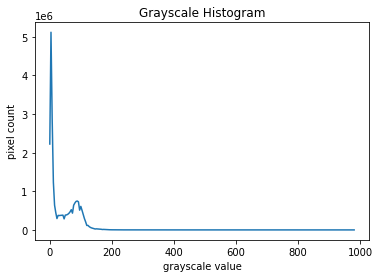

  8%|███▍                                        | 1/13 [00:00<00:04,  2.64it/s]

series:  0
984.0
SHAPE:  (46, 360, 384)
histogram time:  0.06669568177312613


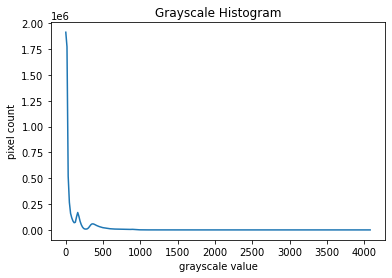

 15%|██████▊                                     | 2/13 [00:00<00:02,  4.09it/s]

series:  1
4095.0
SHAPE:  (23, 360, 384)
histogram time:  0.035378247033804655


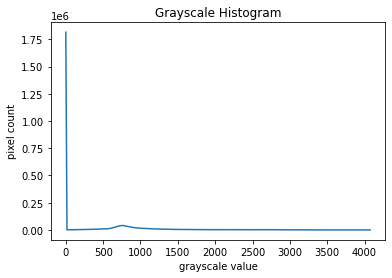

 23%|██████████▏                                 | 3/13 [00:00<00:01,  5.30it/s]

series:  2
4091.0
SHAPE:  (25, 1024, 896)
histogram time:  0.2593454923480749


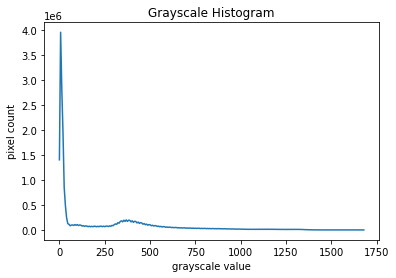

 31%|█████████████▌                              | 4/13 [00:00<00:02,  4.00it/s]

series:  3
1686.0
SHAPE:  (25, 384, 336)
histogram time:  0.060327103827148676


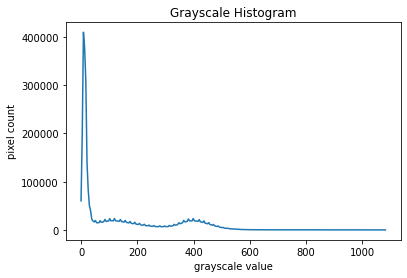

 38%|████████████████▉                           | 5/13 [00:01<00:01,  4.82it/s]

series:  4
1086.0
SHAPE:  (25, 384, 336)
histogram time:  0.05141275189816952


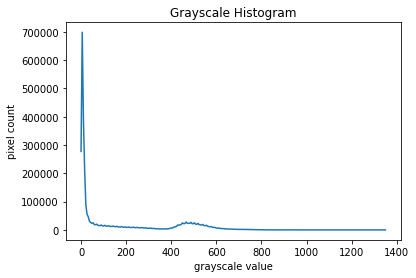

 46%|████████████████████▎                       | 6/13 [00:01<00:01,  5.33it/s]

series:  5
1355.0
SHAPE:  (35, 512, 464)
histogram time:  0.10580535884946585


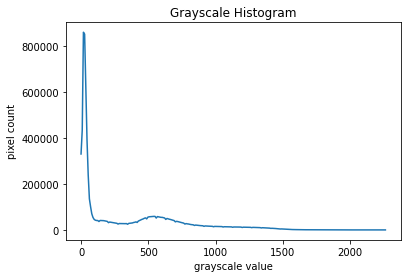

 54%|███████████████████████▋                    | 7/13 [00:01<00:01,  5.45it/s]

series:  6
2272.0
SHAPE:  (22, 384, 346)
histogram time:  0.03556981310248375


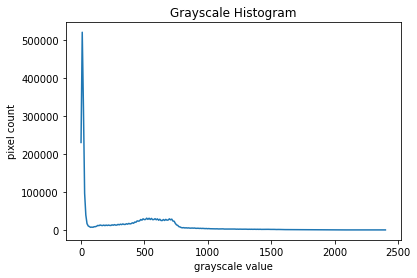

 62%|███████████████████████████                 | 8/13 [00:01<00:00,  6.13it/s]

series:  7
2411.0
SHAPE:  (25, 384, 336)
histogram time:  0.05819080863147974


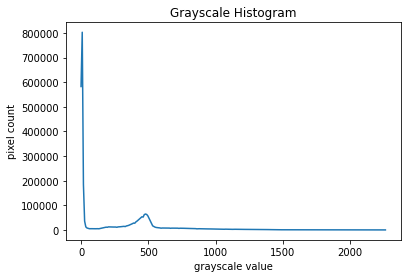

 69%|██████████████████████████████▍             | 9/13 [00:01<00:00,  6.51it/s]

series:  8
2270.0
SHAPE:  (22, 384, 348)
histogram time:  0.03148865094408393


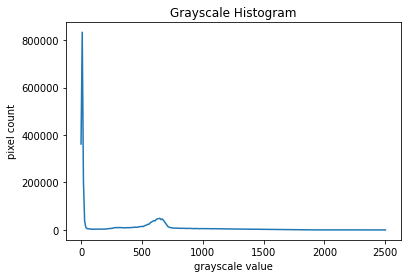

series:  9
2511.0
SHAPE:  (20,)
here in except for  10
histogram time:  0.03036493295803666


/tmp/ipykernel_17529/2106381758.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scan=np.asarray(scan)


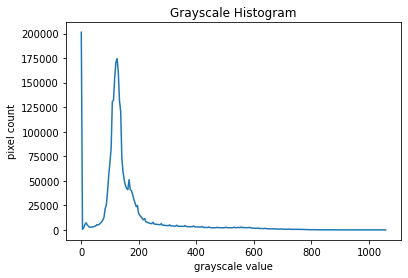

 85%|████████████████████████████████████▍      | 11/13 [00:01<00:00,  7.67it/s]

series:  10
1062.0
SHAPE:  (20,)
here in except for  11
histogram time:  0.03690909966826439


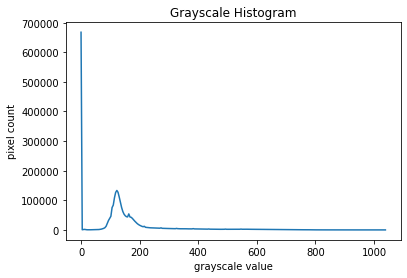

 92%|███████████████████████████████████████▋   | 12/13 [00:02<00:00,  7.90it/s]

series:  11
1043.0
SHAPE:  (20,)
here in except for  12
histogram time:  0.20657650008797646


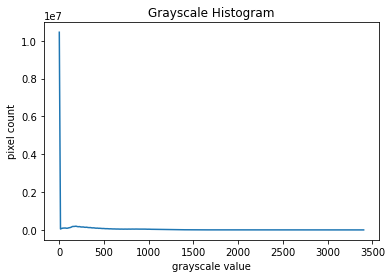

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.63it/s]

series:  12
3416.0


In [91]:
for j in tqdm(range(len(scan_seriesi))):
    scan, names = scan_seriesi[j],filenamesi[j]
    scan=np.asarray(scan)
#     dcmData = pydicom.dcmread(os.path.join(ipath,names[int(scan.shape[0]/2)]))
#     plt.imshow(dcmData.pixel_array,'gray')
#     plt.show()
#     plt.imshow()
    image= scan #[20,:,:]
    print("SHAPE: ", image.shape)
    start = timeit.default_timer()
    try:
        histogram, bin_edges = np.histogram(image, bins=256)
        check=bin_edges[-1]
    except:
        print("here in except for ", j)
        image = []
        for i in range(len(scan_seriesi[j])-1):
            image.append(np.asarray(scan_seriesi[j][i]))
#         print(image.shape)
#         imagee = image[:image.shape[0] - 1]
#         print("subtracted")
#         print(imagee.shape)
        histogram, bin_edges = np.histogram(image, bins=256)
        check=bin_edges[-1]        
    stop = timeit.default_timer()
    print("histogram time: ", stop - start)

    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel count")
    #plt.xlim([-10.0, 1500.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)
    plt.show()
    print("series: ", j)
    print(check)


In [83]:
len(scan_seriesi[10])

20

In [88]:
import copy
s0 = np.asarray(scan_seriesi[10][0])
s0r = s0.shape[1]
s0c = s0.shape[0]
for j in range(len(scan_seriesi[10])-1):
    s = np.asarray(scan_seriesi[10][j])
    if s.shape[0]==s0c and s.shape[1]==s0r:
        print(s.shape)
    else:
        temp = copy.copy(scan_seriesi[10])
        temp.remove(temp[j])
        print("done")

(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)
(384, 384)


In [86]:
print(len(scan_seriesi[10]))

20


In [87]:
print(len(temp))

19


In [68]:
for j in tqdm(range(len(scan_seriesi))):
    scan, names = scan_seriesi[j],filenamesi[j]
    scan=np.asarray(scan)
#     dcmData = pydicom.dcmread(os.path.join(ipath,names[int(scan.shape[0]/2)]))
#     plt.imshow(dcmData.pixel_array,'gray')
#     plt.show()
#     plt.imshow()
    image= scan #[20,:,:]
    print("SHAPE: ", image.shape)
    start = timeit.default_timer()
    try:
        histogram, bin_edges = np.histogram(image, bins=256)
        check=bin_edges[-1]
    except:
        print(image.shape)

  0%|                                                    | 0/13 [00:00<?, ?it/s]

SHAPE:  (225, 384, 288)


 23%|██████████▏                                 | 3/13 [00:00<00:01,  8.35it/s]

SHAPE:  (46, 360, 384)
SHAPE:  (23, 360, 384)
SHAPE:  (25, 1024, 896)


 54%|███████████████████████▋                    | 7/13 [00:00<00:00,  9.87it/s]

SHAPE:  (25, 384, 336)
SHAPE:  (25, 384, 336)
SHAPE:  (35, 512, 464)
SHAPE:  (22, 384, 346)
SHAPE:  (25, 384, 336)


 77%|█████████████████████████████████          | 10/13 [00:00<00:00, 14.46it/s]/tmp/ipykernel_17529/803321014.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scan=np.asarray(scan)
100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 13.67it/s]

SHAPE:  (22, 384, 348)
SHAPE:  (19, 384, 384)
SHAPE:  (20,)
(20,)
SHAPE:  (20,)
(20,)


In [21]:
scan2 = np.asarray(scan_seriesi[2])
scan2.shape

/tmp/ipykernel_17529/460448568.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scan2 = np.asarray(scan_seriesi[2])


(20,)

In [89]:
get_imgs_score(scan_seriesi, filenamesi, opath)

  1%|▍                                          | 3/338 [00:01<02:15,  2.47it/s]


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "/home/minha/FARZEEN/face ann/face mri/output_head/00241178/59ce186ce4b07f3535c1ec11.dcm"

In [60]:
import timeit
def sorted_files_2(folder):
    start = timeit.default_timer()
    ins=[]
    ser=[]
#     f= os.listdir(folder)
    f= sorted(glob.glob((folder + "/**/*.dcm"),recursive = True))
    for name in tqdm( f):
#         itkimage = sitk.ReadImage(os.path.join(folder,name))
#         temp= float(itkimage.GetMetaData('0020|0013')) # instance number 
#         temp1= itkimage.GetMetaData('0020|000e') #series instance UID 
#         row = itkimage.GetMetaData()
        ds = pydicom.dcmread(os.path.join(folder,name))
        temp = ds.InstanceNumber
        temp1 = ds.SeriesInstanceUID
        ins.append(int(temp))
        ser.append(temp1)
    stop = timeit.default_timer()
    print("time for appending: ", stop-start)
    series=np.unique(ser)
    files=[[x for sr,_,x in sorted(zip(ser,ins,f)) if sr==s] for s in series]
    stop2 = timeit.default_timer()
    print("series time: ", stop2-stop)
    return files

def scan_func(path):
    f= sorted_files(path)
    series=[]
    files=[]
    for i in tqdm (range (len(f))):
        img=[]
        file=[]
        for filename in f[i]:
            itkimage = sitk.ReadImage(os.path.join(path,filename))
            row= itkimage.GetMetaData('0020|0010')
            column = itkimage.GetMetaData('0020|0011')
            numpyImage = sitk.GetArrayFromImage(itkimage)
            img.append(numpyImage[0,:,:])
            file.append(filename)
        series.append(img)
        files.append(file)
    return series,files

In [62]:
files = sorted_files_2(ipath)

100%|██████████████████████████████████████| 2012/2012 [00:06<00:00, 303.88it/s]

time for appending:  6.63044131686911
series time:  0.01256177294999361


In [53]:
files

[['/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d46e4b03ed00fb334fa.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d4ee4b03ed00fb334fe.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d57e4b0d2298adad2ed.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d5fe4b03ed00fb33511.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d68e4b03ed00fb3351b.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d70e4b03ed00fb33522.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d79e4b0d2298adad2fd.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d84e4b0d2298adad300.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d8de4b03ed00fb3353f.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92d97e4b03ed00fb3354a.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92da1e4b03ed00fb33557.dcm',
  '/home/abdullah/mri_fa/MRI_DATA_HB/head/06012257/5ae92daae4b03ed00fb33564.dcm',
  '/home/abdulla